In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
# y is the refractive index and the x is the Al content
data = pd.read_csv('glass.dat.txt',sep='\s+')
# print(data)
y=data['RI']
x=data['Al']
rows=data.shape[0]
# print(y.shape)

In [31]:
def gaussian_kernel(u):
    # gaussian kernel is defined as e^(-0.5*^2)/root (2*pi)
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (u ** 2))

def epanechnikov_kernel(u):
    # epanechnikov kernel is defined as 0.75*min(1-u^2,0)
    return 0.75 * (1 - u ** 2) * (np.abs(u) <= 1)

def nadaraya_watson(x_train, y_train, x_point, h, kernel):
    # the estimated regeression is given by the  ratio of the summation of the 
    # product of y_train and kernel function of x_test-x_train/h and the summation
    # of kernel function of x_test-x_train/h over the set of all x_train samples
    nw=[]
    for ele in x_train:
        newx=kernel((x_point-ele)/h)
        nw.append(newx)
    w=np.array(nw)
    return np.sum(w*y_train)/np.sum(w)

def Kfold(x, y, bandwidth,kernal, p=4):
    #Under Kfold we leave out k samples to validate are learning from rest 
    #of the training samples and then keep doing this the whole sample
    n = len(x)
    errors = []
    
    for i in range(n):
        if i<=211:
            idx_val = np.arange(i,min(i+p,n))
            i=i+p
        else:
            idx_val = np.arange(i,min(i+p+1, n))
            i=i+p+1
        idx_val=idx_val.astype(int)
        idx_train = np.delete(np.arange(n), idx_val)
        x_train, y_train = x.iloc[idx_train], y.iloc[idx_train]
        x_val, y_val = x.iloc[idx_val], y.iloc[idx_val]
        y_pred = np.array([nadaraya_watson(x_train, y_train, x_v, bandwidth, kernal) for x_v in x_val])
        
        error = np.mean((y_pred - y_val) ** 2)
        errors.append(error)

    return np.mean(errors)

C:\Users\HP\AppData\Local\Temp\ipykernel_6096\4263946123.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(w*y_train)/np.sum(w)


<function gaussian_kernel at 0x0000024CAF653600>    0.13122448979591836


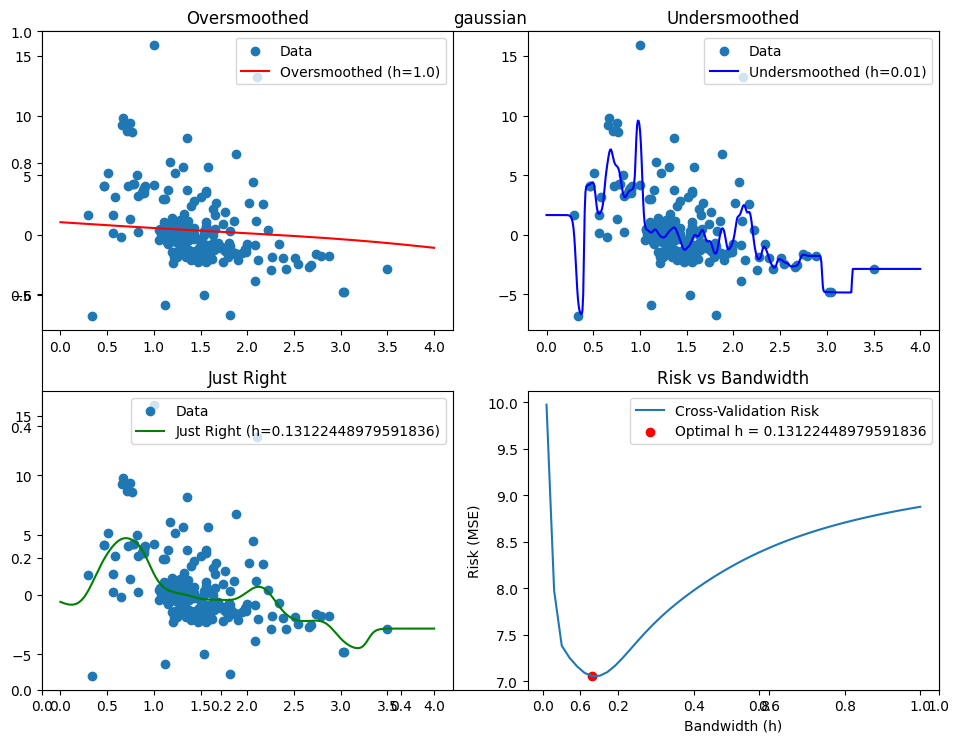

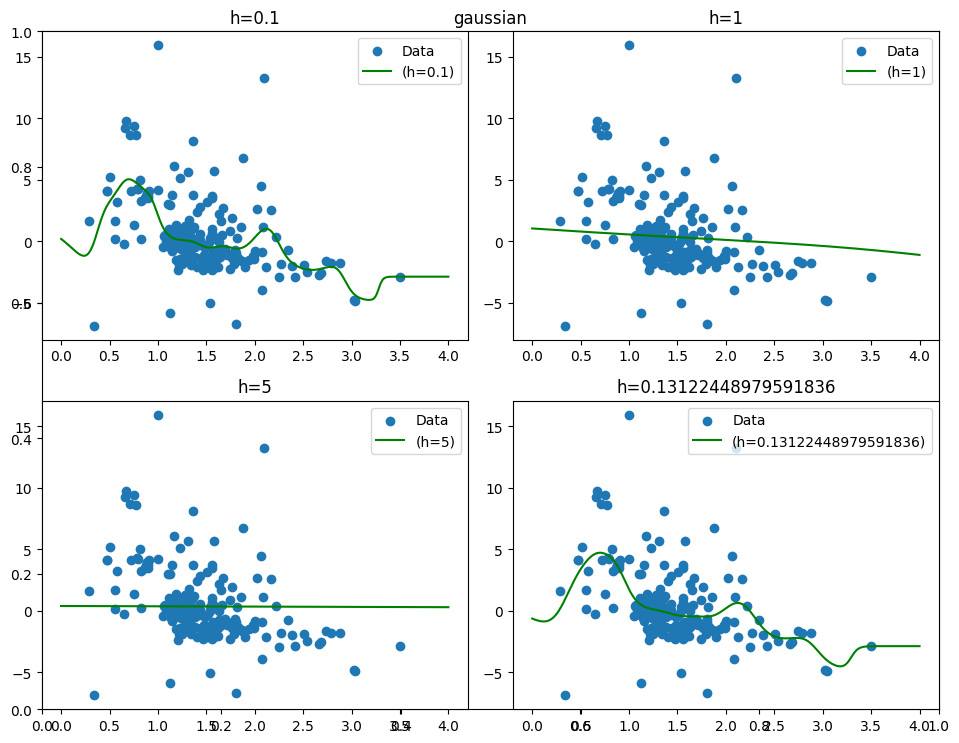

<function epanechnikov_kernel at 0x0000024CAF653BA0>    0.3214285714285714


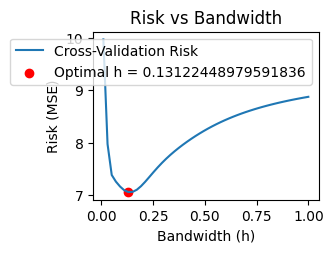

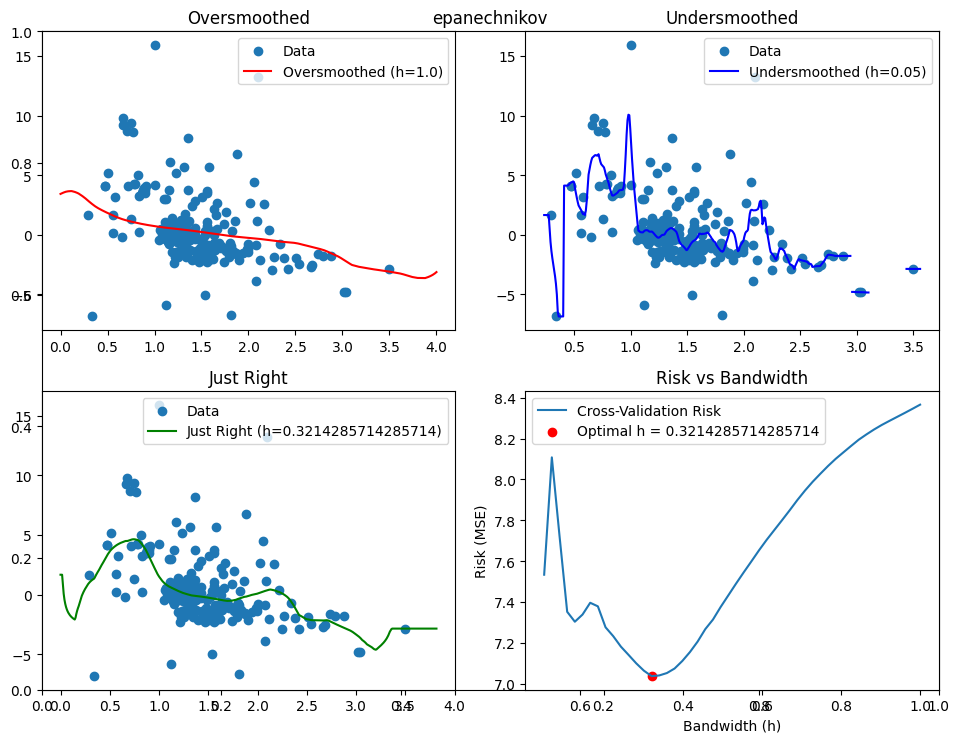

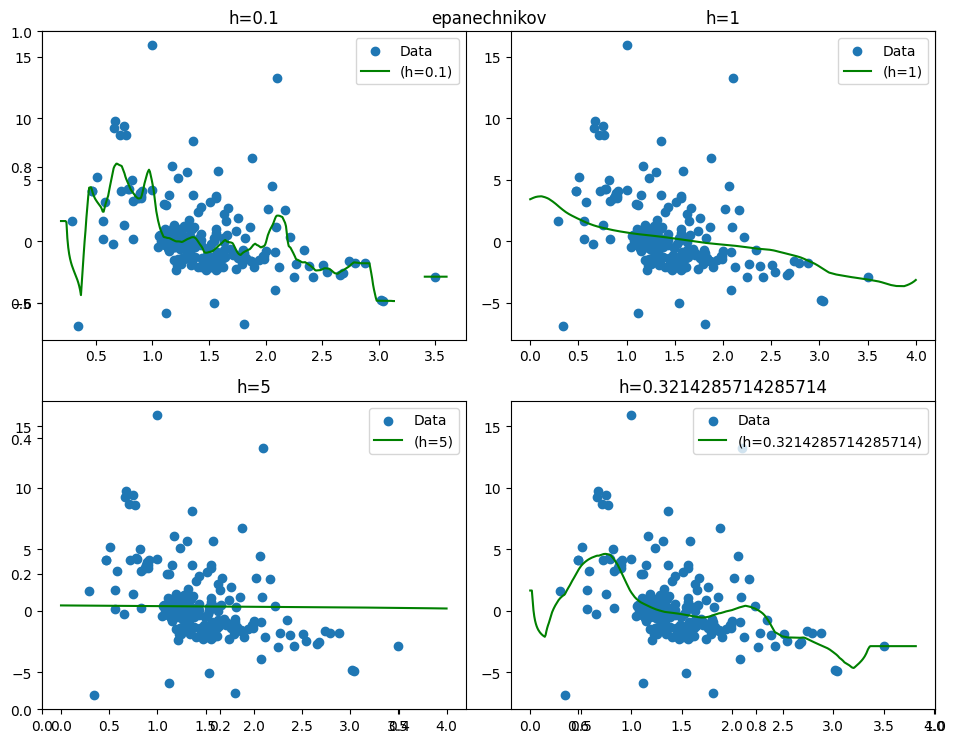

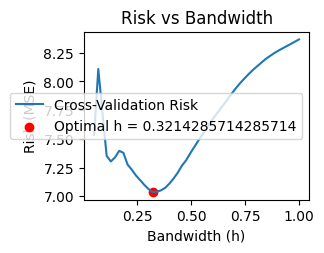

In [40]:
def find_optimal_bandwidth(x, y, kernel, h_values):
    risks = []
    
    for h in h_values:
        risk = Kfold(x, y, h, kernel)
        risks.append(risk)
    
    optimal_h = h_values[np.argmin(risks)]
    print(kernel,"  ",optimal_h)
    return optimal_h, risks

def plotshVsKernel(x,y,kernel,kernel_name,optimal_h,risks):
    h=[0.1,1,5,optimal_h]
    
    plt.figure(figsize=(10,8))
    new_x=np.linspace(0, 4, 500)
    plt.title(f"{kernel_name}")
    for i in range(len(h)):
        hVal=h[i]
        # Just Right
        plt.subplot(2, 2,i+1)
        y_pred_just_right_h = [nadaraya_watson(x, y, x_point, hVal, kernel) for x_point in new_x]
        plt.scatter(x, y, label='Data')
        plt.plot(new_x, y_pred_just_right_h, label=f'(h={hVal})', color='green')
        plt.title(f'h={hVal}')
        plt.legend()

    plt.tight_layout()
    plt.savefig(f"{kernel_name}_kernel_hCompare.png")
    plt.show()

    # Cross-Validation Curve
    plt.subplot(2, 2, 4)
    plt.plot(h_values, risks, label='Cross-Validation Risk')
    plt.scatter([optimal_h], [min(risks)], color='red', label=f'Optimal h = {optimal_h}')
    plt.title('Risk vs Bandwidth')
    plt.xlabel('Bandwidth (h)')
    plt.ylabel('Risk (MSE)')
    plt.legend()


def generate_plots(x, y, kernel, h_values, kernel_name):
    # optimal bandwidth
    optimal_h, risks = find_optimal_bandwidth(x, y, kernel, h_values)
    # Oversmoothed
    small_h = min(h_values)
    # Undersmoothed
    large_h = max(h_values)
    # Just Right
    just_right_h = optimal_h
    # Create subplots
    plt.figure(figsize=(10, 8))
    new_x=np.linspace(0, 4, 500)
    plt.title(kernel_name)
    
    # Oversmoothed
    plt.subplot(2, 2, 1)
    y_pred_large_h = [nadaraya_watson(x, y, x_point, large_h, kernel) for x_point in new_x]
    plt.scatter(x, y, label='Data')
    plt.plot(new_x, y_pred_large_h, label=f'Oversmoothed (h={large_h})', color='red')
    plt.title('Oversmoothed')
    plt.legend()
    
    # Undersmoothed
    plt.subplot(2, 2, 2)
    y_pred_small_h = [nadaraya_watson(x, y, x_point, just_right_h/5, kernel) for x_point in new_x]
    plt.scatter(x, y, label='Data')
    plt.plot(new_x, y_pred_small_h, label=f'Undersmoothed (h={small_h})', color='blue')
    plt.title('Undersmoothed')
    plt.legend()
    
    # Just Right
    plt.subplot(2, 2, 3)
    y_pred_just_right_h = [nadaraya_watson(x, y, x_point, just_right_h, kernel) for x_point in new_x]
    plt.scatter(x, y, label='Data')
    plt.plot(new_x, y_pred_just_right_h, label=f'Just Right (h={just_right_h})', color='green')
    plt.title('Just Right')
    plt.legend()
    
    # Cross-Validation Curve
    plt.subplot(2, 2, 4)
    plt.plot(h_values, risks, label='Cross-Validation Risk')
    plt.scatter([optimal_h], [min(risks)], color='red', label=f'Optimal h = {optimal_h}')
    plt.title('Risk vs Bandwidth')
    plt.xlabel('Bandwidth (h)')
    plt.ylabel('Risk (MSE)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{kernel_name}_kernel_regression.png")
    plt.show()

    plotshVsKernel(x,y,kernel,kernel_name,optimal_h,risks)



h_values = np.linspace(0.01, 1, 50)
generate_plots(x,y,gaussian_kernel,h_values,'gaussian')
h_values = np.linspace(0.05, 1, 50)
generate_plots(x,y,epanechnikov_kernel,h_values,'epanechnikov')

In [42]:
optimal_h_gaussian=0.13122448979591836
riskGaussian=Kfold(x,y,optimal_h_gaussian,gaussian_kernel)
optimal_h_epan=0.3214285714285714
riskE=Kfold(x,y,optimal_h_gaussian,epanechnikov_kernel)
print(f'Gaussian Optimal Risk:{riskGaussian}, Epanechnikov Optimal Risk:{riskE}')


Gaussian Optimal Risk:7.056040105984874, Epanechnikov Optimal Risk:7.315150011042278


C:\Users\HP\AppData\Local\Temp\ipykernel_6096\4263946123.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(w*y_train)/np.sum(w)
